# Classification with PyTorch/TensorFlow

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

## Part 1: Iris Classification

Iris Dataset contains 150 records of 3 different classes of irises. Each record contains 4 numeric parameters: sepal length/width and petal length/width. It is an example of a simple dataset, for which you do not need a powerful neural network.

### Getting the Dataset

Iris dataset is build into Scikit Learn, so we can easily get it:

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
features = iris['data']
labels = iris['target']
class_names = iris['target_names']
feature_names = iris['feature_names']

print(f"Features: {feature_names}, \nClasses: {class_names}")

Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'], 
Classes: ['setosa' 'versicolor' 'virginica']


### Visualize the Data

In many cases, it makes sense to visualize the data to see if they look separable - it would assure us that we should be able to build good classification model. Because we have a few features, we can build a series of pairwise 2D scatter plots, showing different classes by different dot colors. This can be automatically done by a package called **seaborn**:

In [2]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(features,columns=feature_names).join(pd.DataFrame(labels,columns=['Label']))

df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


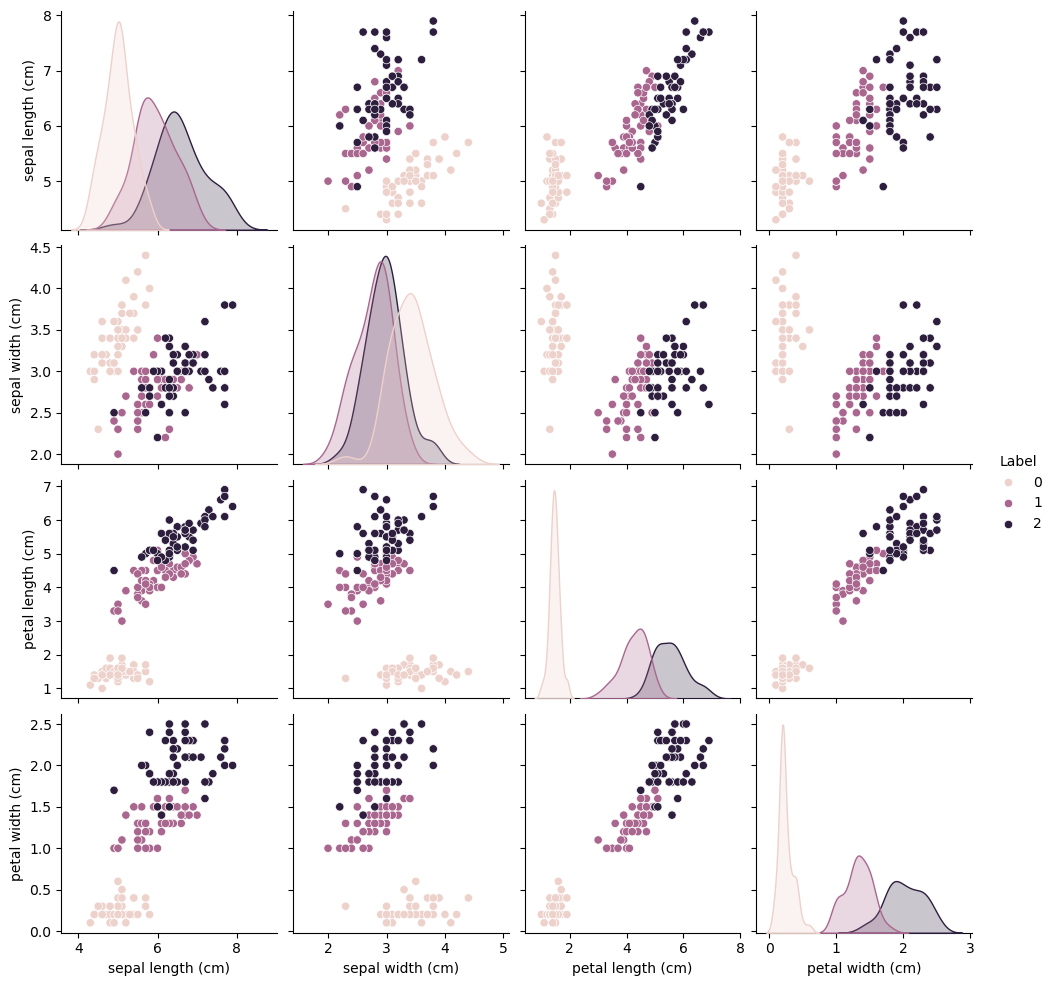

In [3]:
sns.pairplot(df,hue='Label')

### Normalize and Encode the Data

To prepare data to neural network training, we need to normalize inputs in the range [0..1]. This can be done either using plain `numpy` operations, or [Scikit Learn methods](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html).

Also, you need to decide if you want target label to be one-hot encoded or not. PyTorch and TensorFlow allow you feed in class number either as an integer (from 0 to N-1), or as one-hot encoded vector. When creating neural network structure, you need to specify loss function accordingly (eg. *sparse categorical crossentropy* for numeric representation, and *crossentropy loss* for one-hot encoding). One-hot encoding can also be [done using Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), or by using this piece of code:

```python
n_values = np.max(labels) + 1
labels_onehot = np.eye(n_values)[labels]
``` 

In [9]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
print("PyTorch version:", torch.__version__)
print("CUDA version built with:", torch.version.cuda)

PyTorch version: 2.7.1+cu118
CUDA version built with: 11.8


In [7]:
# Code to normalize and encode the data

# normalizing features with StandardScaler
# ensures that each features contributes equally to model's learning process
# averages out each feature's regular value and translates it to zero
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features) # zero mean, unit variance

### Split the Data into Train and Test

Since we do not have separate train and test dataset, we need to split it intro train and test dataset [using Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [8]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(
    features_scaled, labels, test_size=0.2, random_state=42, stratify=labels
)

# convert to pytorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# tensor datasets & dataloaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Define and Train Neural Network

Now you are ready to go, import your preferred framework, define the neural network and start training, observing the behavior of train and validation accuracy.

In [10]:
# Define the network
class IrisNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 16) # 4 features, 16 neurons
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 3) # 3 classes output

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
# Train the network
def train(model, loader, criterion, optimizer, epochs=20):
    model.train() # sets model to training mode

    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in loader: 
            optimizer.zero_grad()               # clear gradients
            outputs = model(inputs)             # forward pass
            loss = criterion(outputs, targets)  # compute loss
            loss.backward()                     # backpropoagate
            optimizer.step()                    # update weights

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

In [17]:
model = IrisNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, train_loader, criterion, optimizer, 30)

Epoch 1, Loss: 1.1353
Epoch 2, Loss: 1.0775
Epoch 3, Loss: 1.0325
Epoch 4, Loss: 1.0071
Epoch 5, Loss: 0.9378
Epoch 6, Loss: 0.9051
Epoch 7, Loss: 0.8735
Epoch 8, Loss: 0.8355
Epoch 9, Loss: 0.8206
Epoch 10, Loss: 0.7811
Epoch 11, Loss: 0.7617
Epoch 12, Loss: 0.7267
Epoch 13, Loss: 0.6833
Epoch 14, Loss: 0.6611
Epoch 15, Loss: 0.6420
Epoch 16, Loss: 0.6210
Epoch 17, Loss: 0.5965
Epoch 18, Loss: 0.5915
Epoch 19, Loss: 0.5539
Epoch 20, Loss: 0.5383
Epoch 21, Loss: 0.5148
Epoch 22, Loss: 0.5070
Epoch 23, Loss: 0.4702
Epoch 24, Loss: 0.4674
Epoch 25, Loss: 0.4539
Epoch 26, Loss: 0.4448
Epoch 27, Loss: 0.4381
Epoch 28, Loss: 0.4193
Epoch 29, Loss: 0.3983
Epoch 30, Loss: 0.4122


In [ ]:
# Visualize train/validation accuracy graph
def evaluate(model, loader):
    model.eval() # set to evaluation mode
    correct, total = 0, 0

    with torch.no_grad(): # no gradients needed for evaluation
        for inputs, targets in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1) # finds max of each row
            total += targets.size(0)             # batch size
            correct += (predicted == targets).sum().item()

    accuracy = correct / total
    print(f"Accuracy: {accuracy * 100:.2f}%")

In [19]:
evaluate(model, test_loader)

Accuracy: 76.67%


In [20]:
import matplotlib.pyplot as plt

def train_and_track(model, train_loader, val_loader, criterion, optimizer, epochs=30):
    train_acc_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Calculate accuracies after epoch
        train_acc = evaluate_acc(model, train_loader)
        val_acc = evaluate_acc(model, val_loader)

        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%")

    # Plot accuracy curves
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), train_acc_history, label='Train Accuracy')
    plt.plot(range(1, epochs+1), val_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [23]:
def evaluate_acc(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return correct / total

Epoch 1, Loss: 0.3738, Train Acc: 87.50%, Val Acc: 76.67%
Epoch 2, Loss: 0.3676, Train Acc: 87.50%, Val Acc: 80.00%
Epoch 3, Loss: 0.3454, Train Acc: 87.50%, Val Acc: 80.00%
Epoch 4, Loss: 0.3371, Train Acc: 87.50%, Val Acc: 80.00%
Epoch 5, Loss: 0.3372, Train Acc: 87.50%, Val Acc: 83.33%
Epoch 6, Loss: 0.3226, Train Acc: 87.50%, Val Acc: 83.33%
Epoch 7, Loss: 0.3129, Train Acc: 87.50%, Val Acc: 83.33%
Epoch 8, Loss: 0.3168, Train Acc: 88.33%, Val Acc: 83.33%
Epoch 9, Loss: 0.3023, Train Acc: 90.83%, Val Acc: 83.33%
Epoch 10, Loss: 0.3082, Train Acc: 90.83%, Val Acc: 83.33%
Epoch 11, Loss: 0.3103, Train Acc: 90.83%, Val Acc: 86.67%
Epoch 12, Loss: 0.2890, Train Acc: 91.67%, Val Acc: 86.67%
Epoch 13, Loss: 0.2848, Train Acc: 91.67%, Val Acc: 86.67%
Epoch 14, Loss: 0.2793, Train Acc: 92.50%, Val Acc: 86.67%
Epoch 15, Loss: 0.2767, Train Acc: 93.33%, Val Acc: 86.67%
Epoch 16, Loss: 0.2699, Train Acc: 93.33%, Val Acc: 86.67%
Epoch 17, Loss: 0.2589, Train Acc: 93.33%, Val Acc: 86.67%
Epoch 

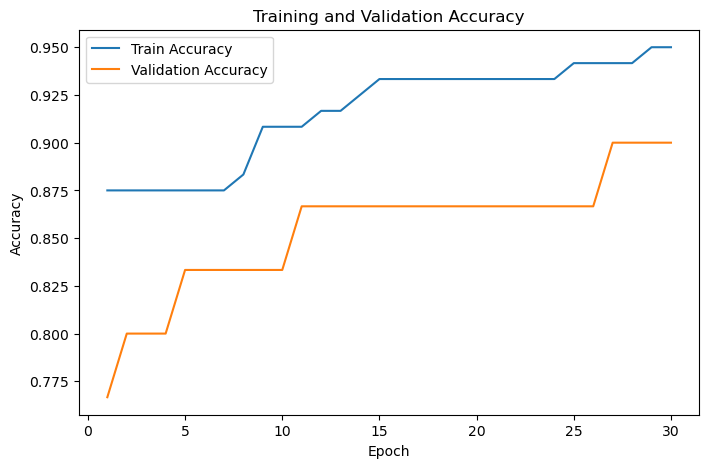

In [24]:
train_and_track(model, train_loader, test_loader, criterion, optimizer, 30)

### Experiment

Now you can experiment with different network architectures to see how it affects the result. Try:
1. One-layer network with 3 neurons (equal to the number of classes)
1. Two-layer network with small/medium/large hidden layer
1. Using more layers

Make sure you observe overfitting when you are using rich model with lots of neurons (parameters).

Epoch 1, Loss: 0.1941, Train Acc: 95.00%, Val Acc: 90.00%
Epoch 2, Loss: 0.1997, Train Acc: 95.00%, Val Acc: 90.00%
Epoch 3, Loss: 0.1997, Train Acc: 95.00%, Val Acc: 90.00%
Epoch 4, Loss: 0.1947, Train Acc: 95.00%, Val Acc: 90.00%
Epoch 5, Loss: 0.1806, Train Acc: 95.00%, Val Acc: 90.00%
Epoch 6, Loss: 0.1827, Train Acc: 95.00%, Val Acc: 90.00%
Epoch 7, Loss: 0.1801, Train Acc: 95.83%, Val Acc: 90.00%
Epoch 8, Loss: 0.1730, Train Acc: 95.00%, Val Acc: 90.00%
Epoch 9, Loss: 0.1724, Train Acc: 95.00%, Val Acc: 90.00%
Epoch 10, Loss: 0.1694, Train Acc: 95.83%, Val Acc: 90.00%
Epoch 11, Loss: 0.1712, Train Acc: 95.83%, Val Acc: 90.00%
Epoch 12, Loss: 0.1749, Train Acc: 95.00%, Val Acc: 90.00%
Epoch 13, Loss: 0.1677, Train Acc: 95.00%, Val Acc: 90.00%
Epoch 14, Loss: 0.1617, Train Acc: 95.00%, Val Acc: 90.00%
Epoch 15, Loss: 0.1566, Train Acc: 95.00%, Val Acc: 90.00%
Epoch 16, Loss: 0.1642, Train Acc: 95.00%, Val Acc: 90.00%
Epoch 17, Loss: 0.1747, Train Acc: 95.83%, Val Acc: 90.00%
Epoch 

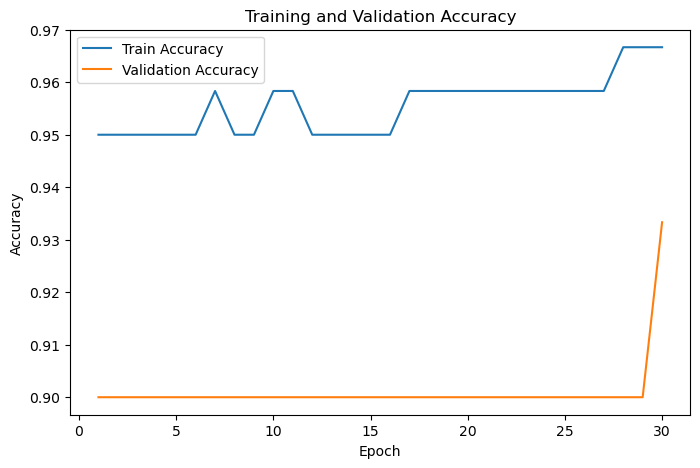

In [28]:
# Experiment 1
class OneLayerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(4, 3) # 4 features, 3 classes)

    def forward(self, x):
        return self.fc(x)
    
modelOne = OneLayerNet()
train_and_track(model, train_loader, test_loader, criterion, optimizer, 30)

In [29]:
class TwoLayerNet(nn.Module):
    def __init__(self, hidden_size=16):
        super().__init__()
        self.fc1 = nn.Linear(4, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
model2sm = TwoLayerNet(hidden_size=8)
model2md = TwoLayerNet(hidden_size=32)
model2lg = TwoLayerNet(hidden_size=64)

Epoch 1, Loss: 1.2050, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 2, Loss: 1.1900, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 3, Loss: 1.1908, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 4, Loss: 1.1905, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 5, Loss: 1.1960, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 6, Loss: 1.1898, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 7, Loss: 1.1880, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 8, Loss: 1.1898, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 9, Loss: 1.1880, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 10, Loss: 1.1945, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 11, Loss: 1.1941, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 12, Loss: 1.2042, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 13, Loss: 1.1917, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 14, Loss: 1.1889, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 15, Loss: 1.1881, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 16, Loss: 1.1913, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 17, Loss: 1.1849, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 

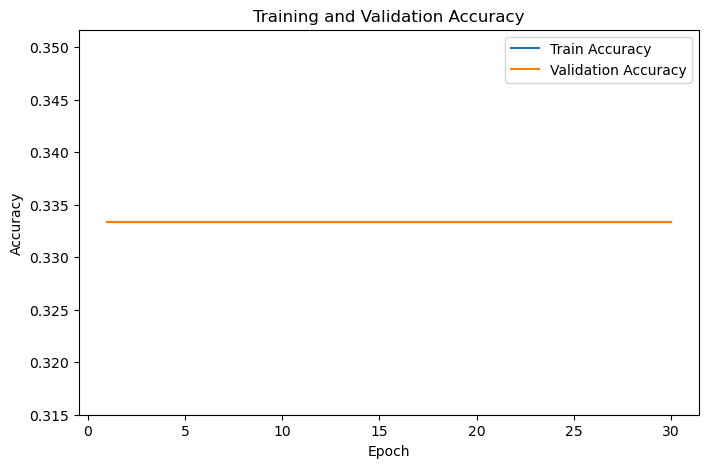

In [30]:
train_and_track(model2sm, train_loader, test_loader, criterion, optimizer)

Epoch 1, Loss: 1.2056, Train Acc: 55.00%, Val Acc: 56.67%
Epoch 2, Loss: 1.1867, Train Acc: 55.00%, Val Acc: 56.67%
Epoch 3, Loss: 1.1848, Train Acc: 55.00%, Val Acc: 56.67%
Epoch 4, Loss: 1.2021, Train Acc: 55.00%, Val Acc: 56.67%
Epoch 5, Loss: 1.1806, Train Acc: 55.00%, Val Acc: 56.67%
Epoch 6, Loss: 1.1909, Train Acc: 55.00%, Val Acc: 56.67%
Epoch 7, Loss: 1.1853, Train Acc: 55.00%, Val Acc: 56.67%
Epoch 8, Loss: 1.1889, Train Acc: 55.00%, Val Acc: 56.67%
Epoch 9, Loss: 1.1814, Train Acc: 55.00%, Val Acc: 56.67%
Epoch 10, Loss: 1.1807, Train Acc: 55.00%, Val Acc: 56.67%
Epoch 11, Loss: 1.1852, Train Acc: 55.00%, Val Acc: 56.67%
Epoch 12, Loss: 1.1829, Train Acc: 55.00%, Val Acc: 56.67%
Epoch 13, Loss: 1.1792, Train Acc: 55.00%, Val Acc: 56.67%
Epoch 14, Loss: 1.1910, Train Acc: 55.00%, Val Acc: 56.67%
Epoch 15, Loss: 1.2074, Train Acc: 55.00%, Val Acc: 56.67%
Epoch 16, Loss: 1.1819, Train Acc: 55.00%, Val Acc: 56.67%
Epoch 17, Loss: 1.1742, Train Acc: 55.00%, Val Acc: 56.67%
Epoch 

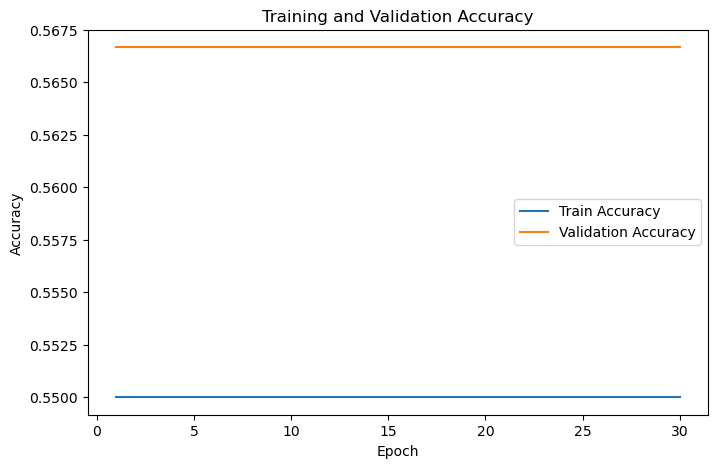

In [31]:
train_and_track(model2md, train_loader, test_loader, criterion, optimizer)

Epoch 1, Loss: 1.2968, Train Acc: 1.67%, Val Acc: 0.00%
Epoch 2, Loss: 1.2985, Train Acc: 1.67%, Val Acc: 0.00%
Epoch 3, Loss: 1.3072, Train Acc: 1.67%, Val Acc: 0.00%
Epoch 4, Loss: 1.2977, Train Acc: 1.67%, Val Acc: 0.00%
Epoch 5, Loss: 1.3020, Train Acc: 1.67%, Val Acc: 0.00%
Epoch 6, Loss: 1.2968, Train Acc: 1.67%, Val Acc: 0.00%
Epoch 7, Loss: 1.3008, Train Acc: 1.67%, Val Acc: 0.00%
Epoch 8, Loss: 1.2934, Train Acc: 1.67%, Val Acc: 0.00%
Epoch 9, Loss: 1.3032, Train Acc: 1.67%, Val Acc: 0.00%
Epoch 10, Loss: 1.2931, Train Acc: 1.67%, Val Acc: 0.00%
Epoch 11, Loss: 1.2983, Train Acc: 1.67%, Val Acc: 0.00%
Epoch 12, Loss: 1.3005, Train Acc: 1.67%, Val Acc: 0.00%
Epoch 13, Loss: 1.2987, Train Acc: 1.67%, Val Acc: 0.00%
Epoch 14, Loss: 1.2955, Train Acc: 1.67%, Val Acc: 0.00%
Epoch 15, Loss: 1.2999, Train Acc: 1.67%, Val Acc: 0.00%
Epoch 16, Loss: 1.2953, Train Acc: 1.67%, Val Acc: 0.00%
Epoch 17, Loss: 1.2960, Train Acc: 1.67%, Val Acc: 0.00%
Epoch 18, Loss: 1.3021, Train Acc: 1.67%

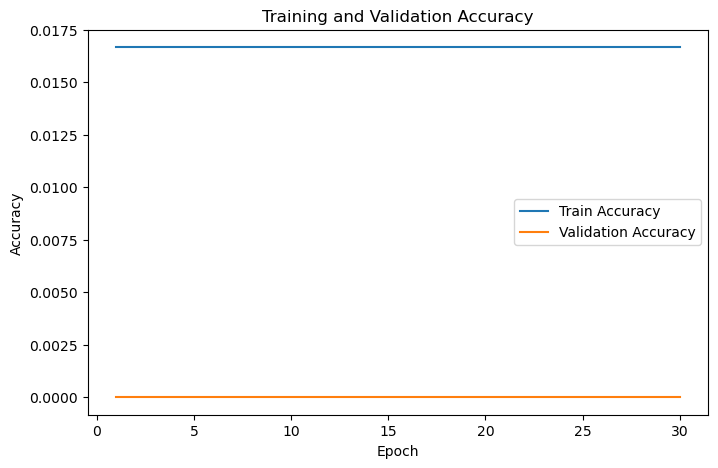

In [32]:
train_and_track(model2lg, train_loader, test_loader, criterion, optimizer)

Epoch 1, Loss: 1.0968, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 2, Loss: 1.1028, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 3, Loss: 1.1022, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 4, Loss: 1.1047, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 5, Loss: 1.1001, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 6, Loss: 1.1028, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 7, Loss: 1.1015, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 8, Loss: 1.0981, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 9, Loss: 1.1015, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 10, Loss: 1.1030, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 11, Loss: 1.0993, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 12, Loss: 1.1030, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 13, Loss: 1.1027, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 14, Loss: 1.0981, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 15, Loss: 1.0995, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 16, Loss: 1.1011, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 17, Loss: 1.1041, Train Acc: 33.33%, Val Acc: 33.33%
Epoch 

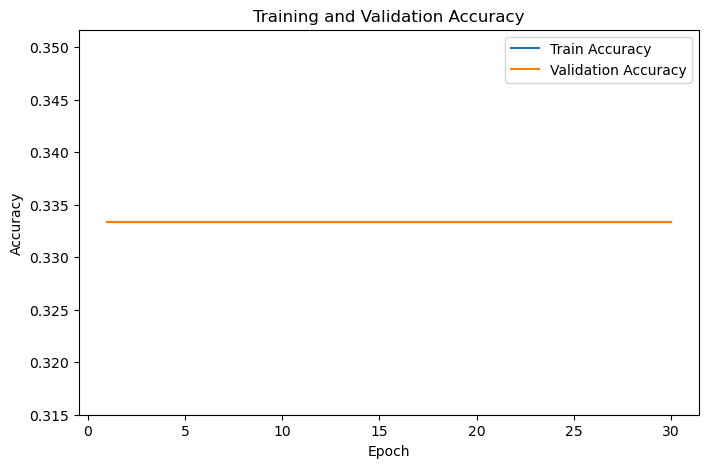

In [33]:
class DeepNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 3),
        )

    def forward(self, x):
        return self.layers(x)
    
modeldeep = DeepNet()
train_and_track(modeldeep, train_loader, test_loader, criterion, optimizer, 30)

## Part 2: MNIST Training

Both Keras and PyTorch contain MNIST as built-in dataset, so you can easily get it with a couple of lines of code ([Keras](https://keras.io/api/datasets/mnist/), [PyTorch](https://pytorch.org/vision/stable/datasets.html)). You will also be able to load both train and test datasets without manually splitting them.

In [ ]:
# Load the dataset

Now you need to perform the steps above to make sure dataset is normalized (it would probably already be), defining and training a neural network.

## Takeaway

1. Neural networks can be used for traditional machine learning tasks. However, they are in many cases too powerful, and can cause overfitting.
1. It is important in this assignment that you observe the overfitting behavior, and try to avoid it.
1. With frameworks like Keras, sometimes training a neural network is quite straightforward. But you need to understand what goes on.